DMO - 2023 - Project 3

Clarice Mottet, Amber Walker, Mox Ballo, Robina Cheng, Rafael Gallegos

Task 4: Consider the procedure devised in Task 3 and fix a given branch and bound iteration and the corresponding callback. Can the procedure result in the same cut being generated twice within the same callback call? Once the cut is addressed in a callback call, the cut should not appear in following callback calls. Within the same callback call, before the cut is addressed, can the same cut be generated more than once?

Response: Within the callback call in Task 3, we use a for loop iterating over nodes from 1 to n to check for subtours. When a subtour is found through the max flow/min cut problem based on the for loop iteration, we apply the SEC constraint and add the subtour to an "added" variable that tracks the nodes present in the subtour we've eliminated. Within the same callback we move to the next iteration of the for loop and if the node is present in a subtour we've already address, stored in the "added" variable, we move to the next iteration of the for loop, or to the next node. Therefore, with the use of the "added" variable that tracks nodes in subtours that have been addressed, we cannot yield the same cut within the same callback call.

If we remove the "added" variable, we can see that we can generate the same cut within the same callback call and below is a simple example showing as such.

In [44]:
from gurobipy import Model, GRB, GurobiError
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import math
from graph_tool.generation import complete_graph
from graph_tool.flow import boykov_kolmogorov_max_flow, min_st_cut

random.seed(120)

In [45]:
#Create a simple example simple x and y coordinates

xs = [1, 1, 4, 4, 6, 6]
ys = [1, 2, 1, 2, 1, 2]
p = [0, 1, 1, 1, 1, 1]
n = len(xs)
V = range(n)
T = 10

In [46]:
# travel times (Euclidean distance divided by speed)
t = {
    (i, j): math.sqrt((xs[i] - xs[j]) ** 2 + (ys[i] - ys[j]) ** 2)
    for i in V for j in V if i != j
}

print(t)

{(0, 1): 1.0, (0, 2): 3.0, (0, 3): 3.1622776601683795, (0, 4): 5.0, (0, 5): 5.0990195135927845, (1, 0): 1.0, (1, 2): 3.1622776601683795, (1, 3): 3.0, (1, 4): 5.0990195135927845, (1, 5): 5.0, (2, 0): 3.0, (2, 1): 3.1622776601683795, (2, 3): 1.0, (2, 4): 2.0, (2, 5): 2.23606797749979, (3, 0): 3.1622776601683795, (3, 1): 3.0, (3, 2): 1.0, (3, 4): 2.23606797749979, (3, 5): 2.0, (4, 0): 5.0, (4, 1): 5.0990195135927845, (4, 2): 2.0, (4, 3): 2.23606797749979, (4, 5): 1.0, (5, 0): 5.0990195135927845, (5, 1): 5.0, (5, 2): 2.23606797749979, (5, 3): 2.0, (5, 4): 1.0}


In [47]:
A = list(t.keys())

m = Model()

m.Params.lazyConstraints = 1

# vars (0 or 1)
y = m.addVars(n, vtype=GRB.BINARY, name="y")
x = m.addVars(A, vtype=GRB.BINARY, name="x")

# objective function
m.setObjective(sum(p[i] * y[i] for i in range(1, n)), GRB.MAXIMIZE)

#constraint 16
m.addConstr(y[0] == 1)  # Repairman starts at the shop

#constraints 17&18
for i in range(n):
    m.addConstr(sum(x[i, j] for j in range(n) if j != i) == y[i])
    m.addConstr(sum(x[j, i] for j in range(n) if j != i) == y[i])

# time constraint 19
m.addConstr(sum(t[i, j] * x[i, j] for i, j in A) <= T)


Set parameter LazyConstraints to value 1


<gurobi.Constr *Awaiting Model Update*>

In [48]:
G = complete_graph(N=n, self_loops=False, directed=True)
cap = G.new_edge_property(value_type='double')
G.edge_properties['cap'] = cap

print(G)

<Graph object, directed, with 6 vertices and 30 edges, 1 internal edge property, at 0x7fea3ddadae0>


In [49]:
def set_capacity():
    for e in G.edges():
        i, j = e.source(), e.target()

        try:
            xval = m.cbGetSolution(x[i,j])
        except GurobiError:
            xval = m.cbGetNodeRel(x[i,j])

        cap[e] = xval        

In [50]:
def add_sec_for(subtour):
    if 0 not in set(subtour):
        print('Added a violated SEC', subtour)
        for k in set(subtour):
            m.cbLazy(sum(x[i,j] for i,j in A if i in subtour and j not in subtour) >= y[k])
        
# adds a subtour elimination constraint to the model when a subtour is detected

In [51]:
def callback(what, where):
    if where not in (GRB.Callback.MIPSOL, GRB.Callback.MIPNODE):
        return
    
    if where == GRB.Callback.MIPNODE and m.cbGet(GRB.Callback.MIPNODE_STATUS) != GRB.OPTIMAL:
        return
    
    print("+++++++++++in callback")
    set_capacity()

    source = G.vertex(0)

    #instead of representing nodes within the set added, we're going to just view the same cuts being generated
    #added is not a dictionary where the keys are the subtour represented as the string and it stores a tuple of the max flow and residual
    added = {}

    for i in range(1, n):
        print("value of i ", i)
        if str(i) in (added.keys()):
            continue

        sink = G.vertex(i)
        res = boykov_kolmogorov_max_flow(g=G, source=source, target=sink, capacity=cap)

        # Create an edge property map quickly by
        # copying an existing one.
        flow = res.copy()

        # The value held by the property map is in
        # the .a member. Because capacity == flow + residuals
        # we must write:
        flow.a = cap.a - res.a

        maxflow = sum(flow[a] for a in sink.in_edges())
        total_res = sum(res[a] for a in sink.in_edges())

        #only say there's a subtour connected to node i if node i is actually connected to other nodes
        try:
            yval = m.cbGetSolution(y[i])
        except GurobiError:
            yval = m.cbGetNodeRel(y[i])

        if (maxflow < (1 - 1e-6)) and yval > .0001:
            print(f"Violated SEC. Flow = {maxflow:.3f} < 1")
            cut = min_st_cut(g=G, source=source, capacity=cap, residual=res)

            try:
                assert cut[source] == True
                assert cut[sink] == False

                subtour_ = [j for j in V if cut[G.vertex(j)] == False]

                # print("base subtour ",subtour_)
                if (len(subtour_) > 1):
                    # # testing for the case where the subtour is length 2
                    # for e in G.edges():
                    #     i_, j_ = e.source(), e.target()
                    #     if i_ == subtour[0] and j_ == subtour[1]:
                    #         print("edge value i ",i_, " j ", j_, cap[e])
                    #     elif i_ == subtour[1] and j_ == subtour[0]:
                    #         print("edge value i ",i_, " j ", j_, cap[e])

                    # #ended up with errors so did error checking
                    # for node in subtour_:
                    #     try:
                    #         yvalnode = m.cbGetSolution(y[node])
                    #     except GurobiError:
                    #         yvalnode = m.cbGetNodeRel(y[node])
                    #     print("node ", node, "yvalue ", yvalnode)

                    iter_ = 0
                    if yval > 0:
                        subtour = []
                        node = i
                        subtour.append(node)
                        stop_ = 0
                        while stop_ == 0:
                            for e in G.edges():
                                iter_+= 1
                                if cap[e] > 0.001:
                                    i_, j_ = int(e.source()), int(e.target())
                                    if node == i_:
                                        if j_ != i:
                                            subtour.append(j_)
                                        node = j_
                                    if node == i:
                                            stop_ = 1
                            # #this was an error stop
                            # if iter_ > 600:
                            #     print("hard stop for loop")
                            #     stop_ = 1

                #error catch
                if len(subtour_) != len(subtour):
                    subtour = subtour_

                assert len(subtour) < n

                add_sec_for(subtour)

                added[str(subtour)] = (maxflow, total_res)

            except AssertionError:
                print("sink issue at ", i)

    print(added)



In [52]:
m.optimize(callback)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2454688 - for non-commercial use only - registered to cl___@bse.eu
Optimize a model with 14 rows, 36 columns and 103 nonzeros
Model fingerprint: 0xd5986f57
Variable types: 0 continuous, 36 integer (36 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
+++++++++++in callback
value of i  1
value of i  2
value of i  3
value of i  4
value of i  5
{}
Found heuristic solution: objective 2.0000000
Presolve removed 1 rows and 1 columns
Presolve time: 0.01s
Presolved: 13 rows, 35 columns, 98 nonzeros
Variable types: 0 continuous, 35 integer (35 binary)

Root relaxation: objective 5.000000e+00, 13 iterations, 0.00 seconds (

Based on the above print out, we can see that it is possible to get the same cut applied within the same callback.

To address this, we'd do what we did in Task 3 and keep the "added" variable as a set of nodes contained in the subtour we're checking and not to repeat a cut if a node is contained within that list.

[0, 2, 3, 1]
time constraint  10
total_time  8.0
total_profit  3


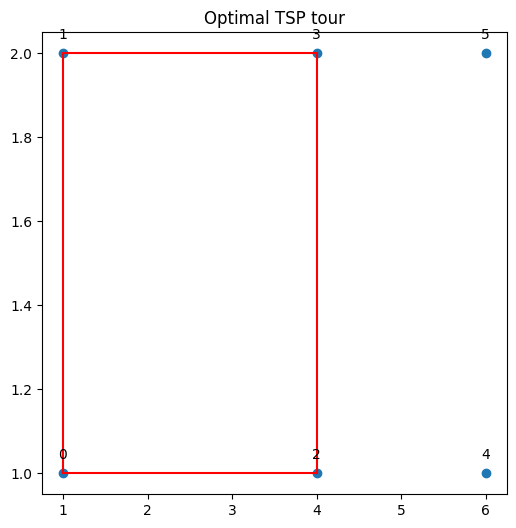

In [53]:
if m.Status == GRB.OPTIMAL or m.Status == GRB.TIME_LIMIT:
    stop_ = 0
    tour = []
    tour.append(0)
    node = 0
    while stop_ == 0:
        for v in m.getVars():
            if v.X > 0:
                var_name = v.VarName
                if var_name[0] == 'x':
                    indices_ = var_name[2:-1]
                    i, j = map(int, indices_.split(','))
                    if i == node:
                        if j != 0:
                            tour.append(j)
                        node = j
                    if node == 0:
                        stop_ = 1

print(tour)

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(xs, ys)
tour2 = tour[1:] + [0]

total_time = 0
total_profit = 0
for i, j in zip(tour, tour2):
    ax.plot((xs[i], xs[j]), (ys[i], ys[j]), color='red')
    total_time += t[i, j]
    total_profit += p[i]

for i, (x, y) in enumerate(zip(xs, ys)):
    ax.annotate(f'{i}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')


print("time constraint ", T)
print("total_time ",total_time)
print("total_profit ", total_profit)
ax.set_title('Optimal TSP tour');